In [1]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
from tqdm import tqdm
import gc
import seaborn as sns
import pickle
from IPython.display import clear_output

import numpy as np
import pandas as pd

from imblearn.under_sampling import RandomUnderSampler 
from sklearn.metrics import classification_report

sns.set_context("notebook", font_scale=1.25)
pd.set_option('display.max_colwidth', 128)
pd.set_option('display.max_columns', 500)

In [2]:
with open('preprocessed.pickle', 'rb') as handle:
    mydict = pickle.load(handle)
    
truth = mydict['truth']
segments = mydict['segments']
mm = mydict['m']
answers = mydict['answers']
model_name = mydict['model_name']

# link to desired concept of truth
truth = truth[['run', 'pid', 'correct', 'hallucinated']]

In [3]:
# minimum generated 
segments[segments.segment=='generated'].length.min()

14

### classifier - generated with maxp/shape/entropy features

In [4]:
mm.run.max()

9

In [5]:
mm.segment.unique()

array(['preamble', 'instruction', 'input', 'question', 'postilla',
       'generated'], dtype=object)

In [6]:
# minimum number of generated tokens
mm[(mm.segment=='generated')].groupby('pid').tokzero.max().min()

14

In [7]:
# check that there are no nulls in generated
mm[(mm.segment=='generated')].isna().sum()

run                      0
pid                      0
tok                      0
area                     0
shape                    0
true_ent                 0
maxp                     0
trans_s                  0
trans_l                  0
logitlens_kl             0
logitlens_iou       340690
start                    0
end                      0
segment                  0
seq                      0
length                   0
tok_rel_segm             0
tok_rel_segm_abs         0
tokzero                  0
tokzero_end              0
dtype: int64

In [8]:
mm.shape

(3705642, 20)

In [9]:
%%time

# take generated 
mmg = mm[mm.segment=='generated']

# expand logitlens kl (for generated only)
df_logitlens_kl_expanded = mmg['logitlens_kl'].apply(pd.Series)
df_logitlens_kl_expanded.columns = [f'logitlens_kl{i}' for i in range(df_logitlens_kl_expanded.shape[1])]

mmg = pd.concat([mmg.drop(columns=['logitlens_kl', 'logitlens_iou']),
                 df_logitlens_kl_expanded], 
                 axis=1)

mmg.shape

CPU times: user 17.4 s, sys: 345 ms, total: 17.7 s
Wall time: 17.7 s


(340690, 49)

In [10]:
%%time

# take postilla
mmp = mm[mm.segment=='postilla']

# expand logitlens kl (for generated only)
df_logitlens_kl_expanded_postilla = mmp['logitlens_kl'].apply(pd.Series)
df_logitlens_kl_expanded_postilla.columns = [f'logitlens_kl{i}' for i in range(df_logitlens_kl_expanded_postilla.shape[1])]

mmp = pd.concat([mmp.drop(columns=['logitlens_kl', 'logitlens_iou']),
                 df_logitlens_kl_expanded_postilla], 
                 axis=1)

mmp.shape

CPU times: user 3.59 s, sys: 74.8 ms, total: 3.66 s
Wall time: 3.66 s


(89298, 49)

In [11]:
%%time

# multiply fishes

runs = pd.DataFrame({"run": range(10)}) 
mmp = mmp.drop(columns=['run']) # only run 0
mmp_e = runs.merge(mmp, how="cross")

mmp_e.shape[0] == 10 * mmp.shape[0]

CPU times: user 82.3 ms, sys: 66.3 ms, total: 149 ms
Wall time: 152 ms


True

In [12]:
# reconstructed vectors for postilla and generated (half a GB)
mmg = pd.concat([mmg, mmp_e], axis=0).sort_values(["run", "pid", "tok"])

In [13]:
# df_logitlens_iou_expanded = mmg['logitlens_iou'].apply(pd.Series)
# df_logitlens_iou_expanded.columns = [f'logitlens_iou{i}' for i in range(df_logitlens_iou_expanded.shape[1])]

# concat with the original
#mmg = pd.concat([mmg.drop(columns=['logitlens_kl', 'logitlens_iou']),
#                     df_logitlens_kl_expanded,
#                     df_logitlens_iou_expanded], axis=1)

In [14]:
mmg[mmg.run==0].groupby(['pid', 'segment']).tokzero.size()

pid   segment  
0     generated    21
      postilla     66
1     generated    23
      postilla     66
2     generated    32
                   ..
1798  postilla     66
1799  generated    25
      postilla     66
1800  generated    36
      postilla     66
Name: tokzero, Length: 2706, dtype: int64

In [15]:
### BEWARE: here we move first generated token in postilla as a FALLBACK (waiting to regenerate files)
### motivated by observability
generated_min = mmg[mmg.segment=='generated'].tokzero.min()
print(generated_min)

postilla_max = mmg[mmg.segment=='postilla'].tokzero.max()
print(postilla_max)

# NO MORE
# mask = (mmg.segment=='generated') & (mmg.tokzero==0)
# mmg.loc[mask, 'tokzero'] = postilla_max + 1
# mmg.loc[mask, 'segment'] = 'postilla'

# just clip tokzero == 0
print(mmg.shape)
mmg = mmg.drop(mmg[(mmg.segment=='generated') & (mmg.tokzero==0)].index)
print(mmg.shape)

0
65


In [16]:
generated_min = mmg[mmg.segment=='generated'].tokzero.min()
print(generated_min)

postilla_max = mmg[mmg.segment=='postilla'].tokzero.max()
print(postilla_max)

0
65


### create dataset for generation

In [17]:
%%time

# beginning of generation
N = 10

selected_features = ['shape', 'true_ent', 'maxp']

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<=N)][['run', 'pid', 'tokzero'] + selected_features]

# WARNING: pivoting will generate null values if N < min generated length
ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

CPU times: user 90 ms, sys: 12.1 ms, total: 102 ms
Wall time: 102 ms


In [18]:
ds.correct.value_counts()

correct
True     11970
False     1560
Name: count, dtype: int64

In [19]:
ds.shape

(13530, 37)

In [20]:
# WARNING here we are dropping duplicates (and cases where |generated| < N)
ds = ds.dropna().drop_duplicates(ds.columns[1:-1])

In [21]:
ds.shape

(1680, 37)

In [22]:
y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

In [23]:
X.loc[:,X.nunique()!=1].shape

(1680, 32)

In [24]:
X.isnull().sum().sum() == 0

True

In [25]:
# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

y_res_generated = y_res

X_res.columns = ['generated_'+col for col in X.columns]

In [26]:
X_res.isnull().sum().sum() == 0

True

### beginning of generation

In [27]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost

class_counts = np.bincount(y_res)
class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
sample_weights = np.array([class_weights[y] for y in y_res])

#partition cv by prompt
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)

# pred = cross_val_predict(xgb_model, X, y, cv=GroupKFold(n_splits=10), groups=pids)
# pred_proba = cross_val_predict(xgb_model, X, y, cv=LeaveOneGroupOut(), groups=pids, method='predict_proba')

pred_proba_generated = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), 
                               groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})

CPU times: user 6.27 s, sys: 608 ms, total: 6.87 s
Wall time: 900 ms


In [28]:
pred = pred_proba_generated.argmax(axis=1).astype(bool)
print(classification_report(y_res_generated.values, pred))

              precision    recall  f1-score   support

       False       0.63      0.67      0.65       383
        True       0.90      0.89      0.89      1297

    accuracy                           0.84      1680
   macro avg       0.77      0.78      0.77      1680
weighted avg       0.84      0.84      0.84      1680



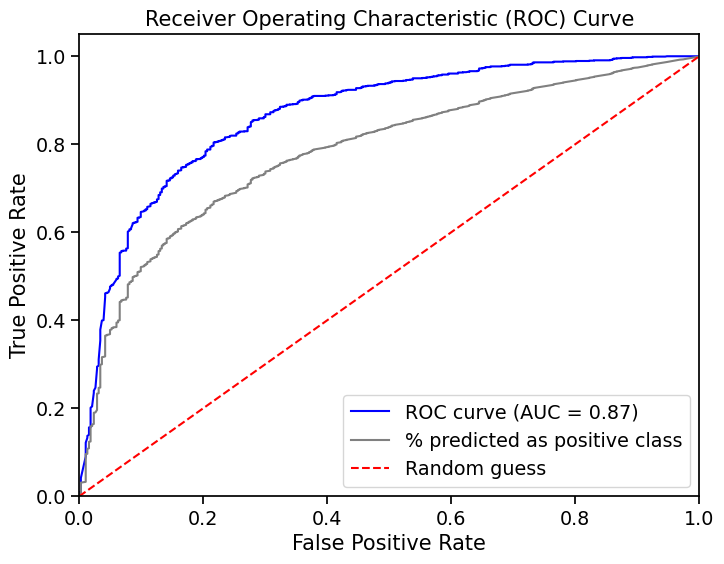

In [29]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res_generated.values, pred_proba_generated[:, 1])
true_counts_rel = [(pred_proba_generated[:, 1] > thr).sum() / len(y_res_generated.values) for thr in thresholds]

roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='grey', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [30]:
%%time

import lightgbm as lgb
import shap

model = lgb.LGBMClassifier(n_estimators=100, boosting_type='gbdt')
model.fit(X_res, y_res)

explainer = shap.TreeExplainer(model, X_res)

shap_values = explainer(X_res, check_additivity=False)

[LightGBM] [Info] Number of positive: 1297, number of negative: 383
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5140
[LightGBM] [Info] Number of data points in the train set: 1680, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772024 -> initscore=1.219774
[LightGBM] [Info] Start training from score 1.219774
CPU times: user 8.62 s, sys: 1.81 s, total: 10.4 s
Wall time: 7.02 s


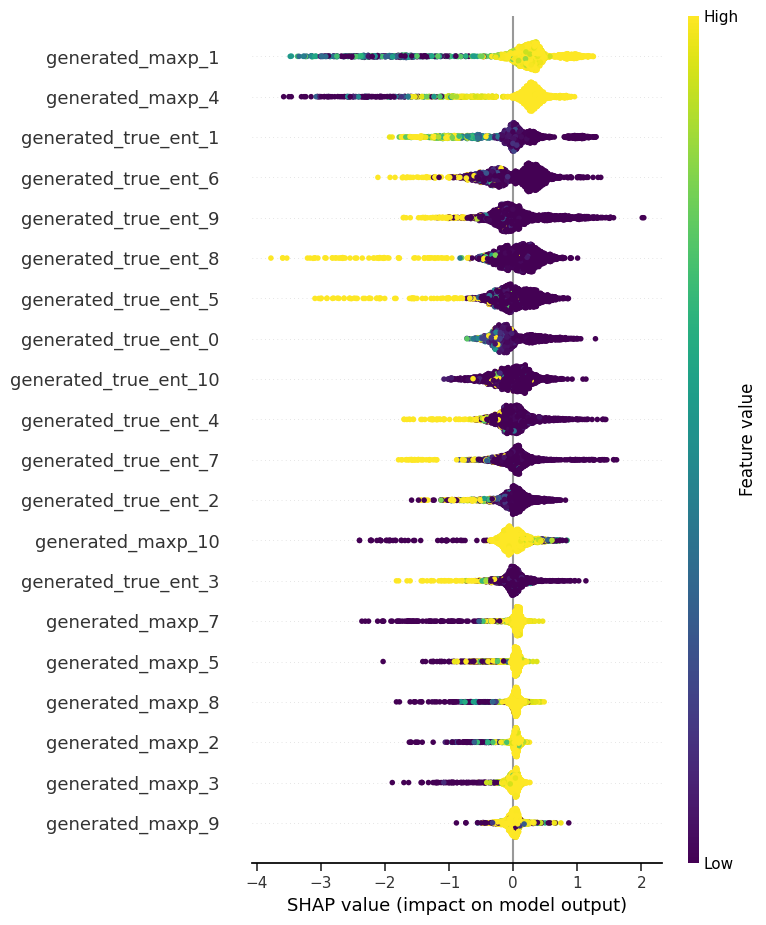

In [31]:
shap.summary_plot(shap_values, X_res, cmap="viridis")

In [32]:
# shap.plots.heatmap(shap_values, cmap="RdBu_r")

In [33]:
#clustering = shap.utils.hclust(X_res, y_res)
#shap.plots.bar(shap_values, clustering=clustering, max_display=20, clustering_cutoff=1)

In [34]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x.split('_')[-1] if i.isdigit()))
vals['label'] = vals['label'].astype(int)

In [36]:
vals.groupby('grp').value.sum()

grp
generated_maxp_        0.349207
generated_shape_       0.019188
generated_true_ent_    0.631605
Name: value, dtype: float64

In [37]:
K = 10
top_feat_generated_begin = vals.sort_values('value', ascending=False)[:K].label_orig.tolist()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


The palette list has fewer values (10) than needed (11) and will cycle, which may produce an uninterpretable plot.


<Axes: xlabel='label', ylabel='value'>

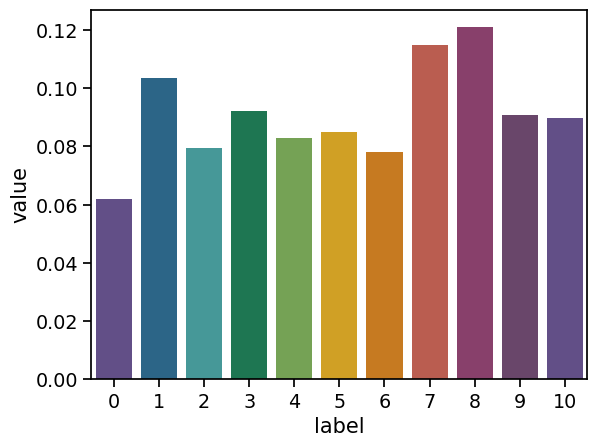

In [38]:
from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

index_importances = vals.sort_index().groupby('label').value.sum()

sns.barplot(index_importances, palette=palette)

Text(27.44444444444443, 0.5, 'Token index')

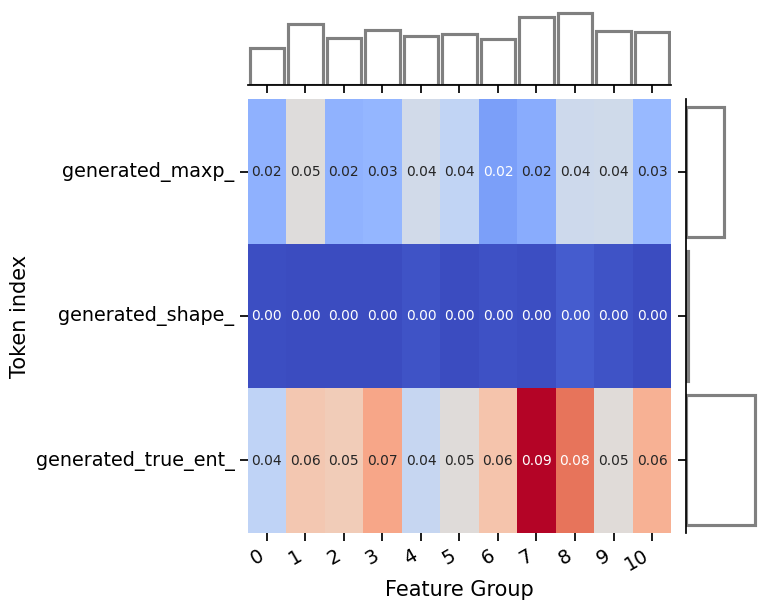

In [39]:
_toplot = vals.pivot_table(index=['grp'], columns='label', values='value', aggfunc='sum')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")
# Draw total bars, both with width 1, but the Y one with horizontal orientation

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.9, fill=False, color='grey')

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.9, fill=False, color='grey')

# Offset value (just half an unit)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

# Need to use this to set the horizontal_alignment
grid.ax_joint.set_xticklabels(
    grid.ax_joint.get_xticklabels(), 
    rotation=30,    
    ha='right'
)
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Feature Group')
grid.ax_joint.set_ylabel('Token index')

### generated with all features (+kl)

In [40]:
%%time

# beginning of generation
N = 10

selected_features = ['true_ent', 'maxp'] + list(df_logitlens_kl_expanded.columns)

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

# WARNING here we are dropping duplicates
ds = ds.drop_duplicates(ds.columns[1:-1])

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

y_res_generated_all = y_res

X_res.columns = ['generated_'+col for col in X.columns]

CPU times: user 385 ms, sys: 76 ms, total: 461 ms
Wall time: 336 ms


In [41]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost

class_counts = np.bincount(y_res)
class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
sample_weights = np.array([class_weights[y] for y in y_res])

#partition cv by prompt
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)

pred_proba_all = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), 
                               groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})

CPU times: user 1min 11s, sys: 5.67 s, total: 1min 16s
Wall time: 12.7 s


In [42]:
y_res_generated.shape, y_res_generated_all.shape

((4088,), (5644,))

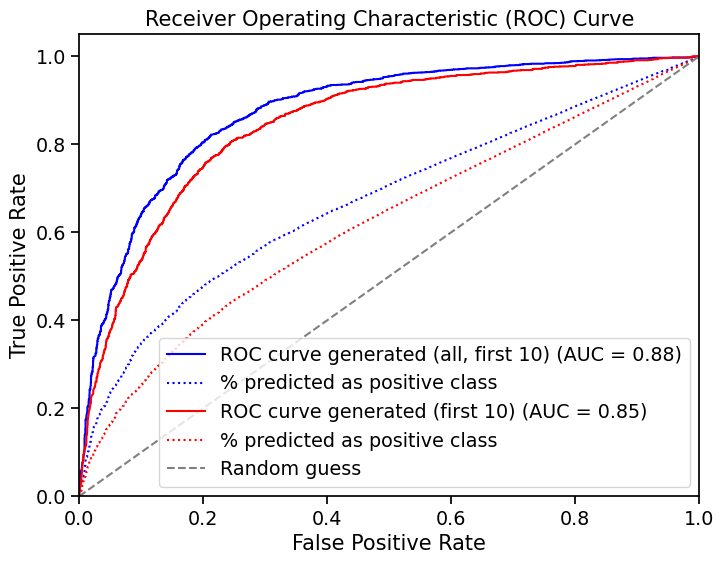

In [43]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res_generated_all.values, pred_proba_all[:, 1])
true_counts_rel = [(pred_proba_all[:, 1] > thr).sum() / pred_proba_all.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve generated (all, first {N}) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')

fpr, tpr, thresholds = roc_curve(y_res_generated.values, pred_proba_generated[:, 1])
true_counts_rel = [(pred_proba_generated[:, 1] > thr).sum() / pred_proba_generated.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', label=f'ROC curve generated (first {N}) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [44]:
%%time

import lightgbm as lgb
import shap

model = lgb.LGBMClassifier(n_estimators=100, boosting_type='gbdt')
model.fit(X_res, y_res)

explainer = shap.TreeExplainer(model, X_res)

shap_values = explainer(X_res, check_additivity=False)

# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x.split('_')[-1] if i.isdigit()))
vals['label'] = vals['label'].astype(int)

vals.groupby('grp').value.sum()

[LightGBM] [Info] Number of positive: 2586, number of negative: 3058
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 73864
[LightGBM] [Info] Number of data points in the train set: 5644, number of used features: 290
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458186 -> initscore=-0.167649
[LightGBM] [Info] Start training from score -0.167649


 98%|===================| 5513/5644 [00:21<00:00]        

CPU times: user 26.4 s, sys: 2.84 s, total: 29.2 s
Wall time: 21.9 s


grp
generated_logitlens_kl_    0.714945
generated_maxp_            0.113794
generated_true_ent_        0.171261
Name: value, dtype: float64



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Axes: xlabel='label', ylabel='value'>

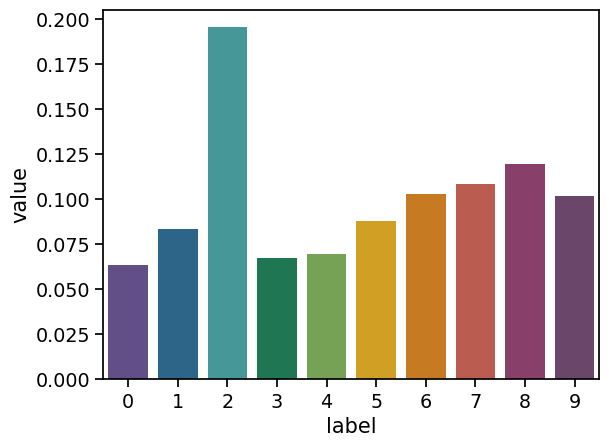

In [45]:
from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

index_importances = vals.sort_index().groupby('label').value.sum()

sns.barplot(index_importances, palette=palette)

Text(27.44444444444443, 0.5, 'Token index')

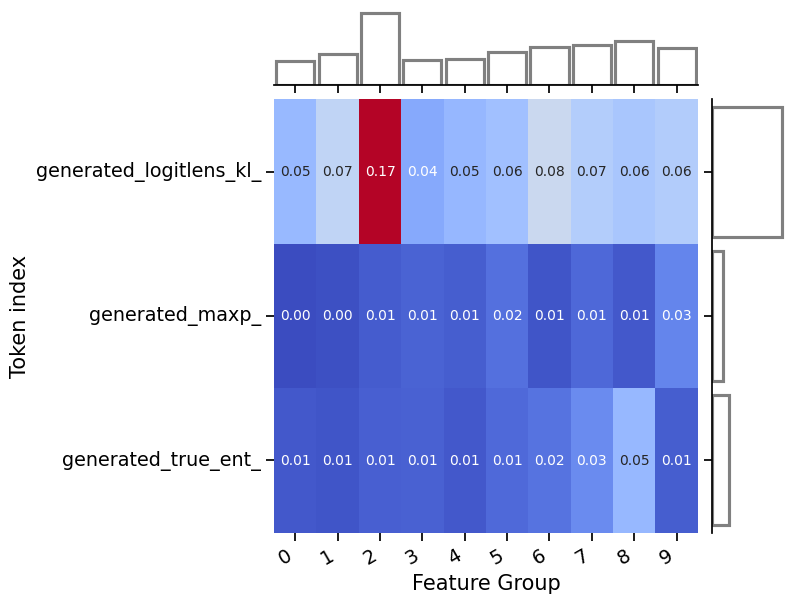

In [46]:
_toplot = vals.pivot_table(index=['grp'], columns='label', values='value', aggfunc='sum')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")
# Draw total bars, both with width 1, but the Y one with horizontal orientation

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.9, fill=False, color='grey')

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.9, fill=False, color='grey')

# Offset value (just half an unit)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

# Need to use this to set the horizontal_alignment
grid.ax_joint.set_xticklabels(
    grid.ax_joint.get_xticklabels(), 
    rotation=30,    
    ha='right'
)
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Feature Group')
grid.ax_joint.set_ylabel('Token index')

### only kl

In [47]:
%%time

# beginning of generation
N = 10

selected_features = list(df_logitlens_kl_expanded.columns)

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

# WARNING here we are dropping duplicates
ds = ds.drop_duplicates(ds.columns[1:-2])

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

y_res_generated_kl = y_res

X_res.columns = ['generated_'+col for col in X.columns]

CPU times: user 360 ms, sys: 45.4 ms, total: 405 ms
Wall time: 256 ms


In [48]:
%%time

import xgboost
import shap

model = xgboost.XGBClassifier(n_estimators=100, booster='gbtree').fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

 99%|===================| 5393/5460 [00:17<00:00]        

CPU times: user 24.4 s, sys: 1.16 s, total: 25.5 s
Wall time: 18.1 s


In [49]:
# ONLY for layer-wise drilldown!
# grp in the layer

# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : int(''.join(i for i in x.split('_')[-2] if i.isdigit())))
# vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : int(''.join(i for i in x.split('_')[-1] if i.isdigit())))
vals['label'] = vals['label'].astype(int)

In [50]:
# find boundaries
# this is done the first time X_res contains logitlens colums

klnames = [c for c in X_res.columns if 'logitlens' in c]
import re
maxtok = max([int(re.sub(r"\D", "", k.split('_')[-1])) for k in klnames]) + 1
maxlayer = max([int(re.sub(r"\D", "", k.split('_')[-2])) for k in klnames]) + 1

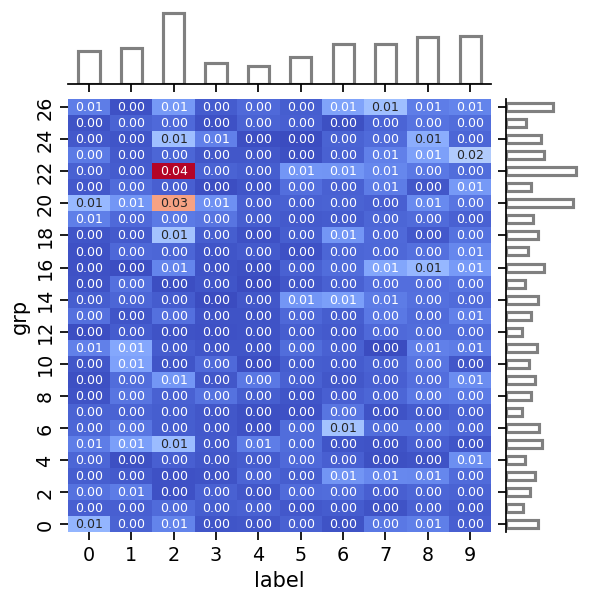

In [51]:


_toplot = vals.pivot_table(index=['grp'], columns='label', values='value', aggfunc='sum')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":9}, cmap="coolwarm")

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.5, fill=False, color='grey')
grid.ax_joint.set_ylim(0, maxtok)

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.5, fill=False, color='grey')
grid.ax_joint.set_ylim(0, maxlayer)

# Offset value (just half an unit)
_off = .5

_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)


# Fix y
# _ymin, _ymax = grid.ax_joint.get_ylim()
# grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

In [52]:
%%time
import lightgbm as lgb
import shap

model = lgb.LGBMClassifier(n_estimators=100, boosting_type='dart')
model.fit(X_res, y_res)

explainer = shap.TreeExplainer(model, X_res, feature_perturbation="interventional")

shap_values = explainer(X_res, check_additivity=False)

[LightGBM] [Info] Number of positive: 2474, number of negative: 2986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 68850
[LightGBM] [Info] Number of data points in the train set: 5460, number of used features: 270
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.453114 -> initscore=-0.188098
[LightGBM] [Info] Start training from score -0.188098


 97%|=================== | 5315/5460 [00:20<00:00]       

CPU times: user 28.7 s, sys: 4.43 s, total: 33.1 s
Wall time: 21.9 s


In [53]:
# ONLY for layer-wise drilldown!
# grp in the layer

# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : int(''.join(i for i in x.split('_')[-2] if i.isdigit())))
# vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : int(''.join(i for i in x.split('_')[-1] if i.isdigit())))
vals['label'] = vals['label'].astype(int)

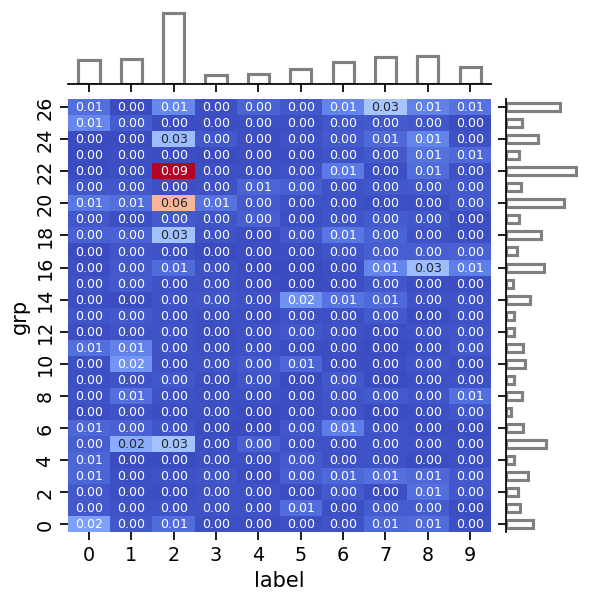

In [54]:
# find boundaries
klnames = [c for c in X_res.columns if 'logitlens' in c]
import re
maxtok = max([int(re.sub(r"\D", "", k.split('_')[-1])) for k in klnames]) + 1
maxlayer = max([int(re.sub(r"\D", "", k.split('_')[-2])) for k in klnames]) + 1

_toplot = vals.pivot_table(index=['grp'], columns='label', values='value', aggfunc='sum')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":9}, cmap="coolwarm")

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.5, fill=False, color='grey')
grid.ax_joint.set_ylim(0, maxtok)

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.5, fill=False, color='grey')
grid.ax_joint.set_ylim(0, maxlayer)

# Offset value (just half an unit)
_off = .5

_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)


# Fix y
# _ymin, _ymax = grid.ax_joint.get_ylim()
# grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

In [55]:
%%time
import lightgbm as lgb
import shap

model = lgb.LGBMClassifier(n_estimators=100, boosting_type='gbdt')
model.fit(X_res, y_res)

explainer = shap.TreeExplainer(model, X_res)

shap_values = explainer(X_res, check_additivity=False)

[LightGBM] [Info] Number of positive: 2474, number of negative: 2986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 68850
[LightGBM] [Info] Number of data points in the train set: 5460, number of used features: 270
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.453114 -> initscore=-0.188098
[LightGBM] [Info] Start training from score -0.188098


 98%|===================| 5340/5460 [00:20<00:00]        

CPU times: user 27.9 s, sys: 3.9 s, total: 31.8 s
Wall time: 21.5 s


In [56]:
# ONLY for layer-wise drilldown!
# grp in the layer

# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : int(''.join(i for i in x.split('_')[-2] if i.isdigit())))
# vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : int(''.join(i for i in x.split('_')[-1] if i.isdigit())))
vals['label'] = vals['label'].astype(int)

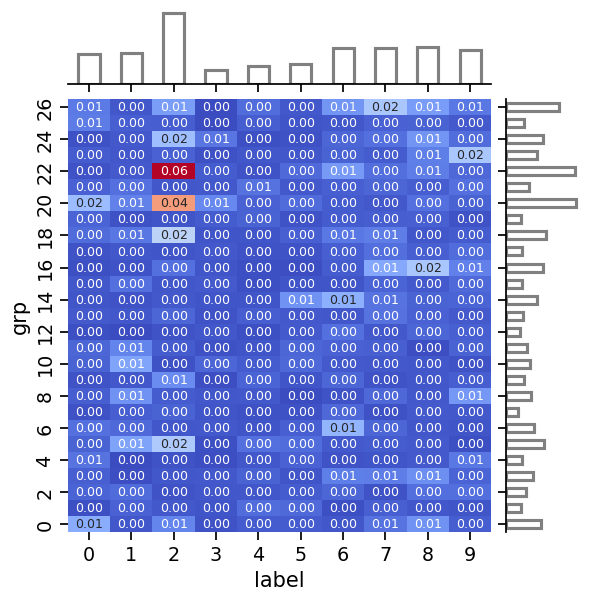

In [57]:
# find boundaries
klnames = [c for c in X_res.columns if 'logitlens' in c]
import re
maxtok = max([int(re.sub(r"\D", "", k.split('_')[-1])) for k in klnames]) + 1
maxlayer = max([int(re.sub(r"\D", "", k.split('_')[-2])) for k in klnames]) + 1

_toplot = vals.pivot_table(index=['grp'], columns='label', values='value', aggfunc='sum')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":9}, cmap="coolwarm")

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.5, fill=False, color='grey')
grid.ax_joint.set_ylim(0, maxtok)

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.5, fill=False, color='grey')
grid.ax_joint.set_ylim(0, maxlayer)

# Offset value (just half an unit)
_off = .5

_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)


# Fix y
# _ymin, _ymax = grid.ax_joint.get_ylim()
# grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

In [58]:
# for later use
besties = list(vals.sort_values('value', ascending=False)[:10].label_orig)
besties

['generated_logitlens_kl22_2',
 'generated_logitlens_kl20_2',
 'generated_logitlens_kl18_2',
 'generated_logitlens_kl5_2',
 'generated_logitlens_kl23_9',
 'generated_logitlens_kl16_8',
 'generated_logitlens_kl26_7',
 'generated_logitlens_kl24_2',
 'generated_logitlens_kl20_0',
 'generated_logitlens_kl6_6']

### postilla

In [59]:
mmg[(mmg.segment=='postilla')].tokzero.max()

58

In [60]:
# end of ...
# ds = mm[(mm.segment=='postilla') & (mm.tokzero_end>=-10)][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]

selected_features = ['true_ent', 'maxp'] 

# all postilla
ds = mmg[(mmg.segment=='postilla')][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
#ds = ds.pivot(index=['run', 'pid'], columns='tokzero_end', values=['shape', 'maxp', 'true_ent']).reset_index()

# WARNING: pivoting will generate null values if N < min generated length
ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.merge(truth, on=['run', 'pid'])

# WARNING here we are dropping duplicates
ds = ds.drop_duplicates(ds.columns[1:-1])

print(ds.shape)

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]
y_res_postilla = y_res

X_res.columns = ['postilla_'+col for col in X.columns]

(2121, 122)


In [61]:
y_res_postilla.shape, y_res_generated.shape

((2121,), (4088,))

In [62]:
%%time

class_counts = np.bincount(y_res)
class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
sample_weights = np.array([class_weights[y] for y in y_res])

xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)
# pred_proba_instr = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res, method='predict_proba')
pred_proba_postilla = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), 
                                     groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})

CPU times: user 20.6 s, sys: 3.24 s, total: 23.8 s
Wall time: 3.67 s


In [63]:
pred = pred_proba_postilla.argmax(axis=1).astype(bool)
print(classification_report(y_res_postilla.values, pred))

              precision    recall  f1-score   support

       False       0.53      0.61      0.57       975
        True       0.62      0.54      0.57      1146

    accuracy                           0.57      2121
   macro avg       0.57      0.57      0.57      2121
weighted avg       0.58      0.57      0.57      2121



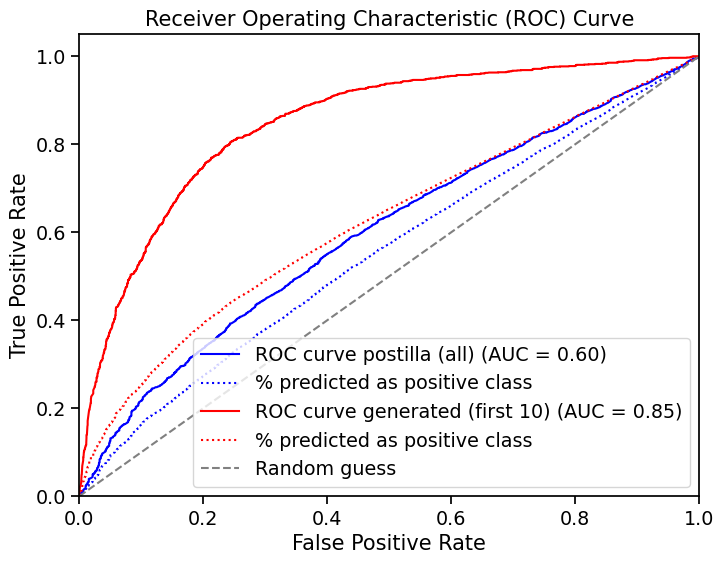

In [64]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res_postilla.values, pred_proba_postilla[:, 1])
true_counts_rel = [(pred_proba_postilla[:, 1] > thr).sum() / pred_proba_postilla.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve postilla (all) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res_generated.values, pred_proba_generated[:, 1])
true_counts_rel = [(pred_proba_generated[:, 1] > thr).sum() / pred_proba_generated.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', label=f'ROC curve generated (first {N}) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [65]:
%%time
import lightgbm as lgb
import shap

model = lgb.LGBMClassifier(n_estimators=100, boosting_type='gbdt')
model.fit(X_res, y_res)

explainer = shap.TreeExplainer(model, X_res)

shap_values = explainer(X_res, check_additivity=False)

[LightGBM] [Info] Number of positive: 1146, number of negative: 975
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20979
[LightGBM] [Info] Number of data points in the train set: 2121, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.540311 -> initscore=0.161595
[LightGBM] [Info] Start training from score 0.161595
CPU times: user 10.3 s, sys: 1.76 s, total: 12.1 s
Wall time: 8.35 s


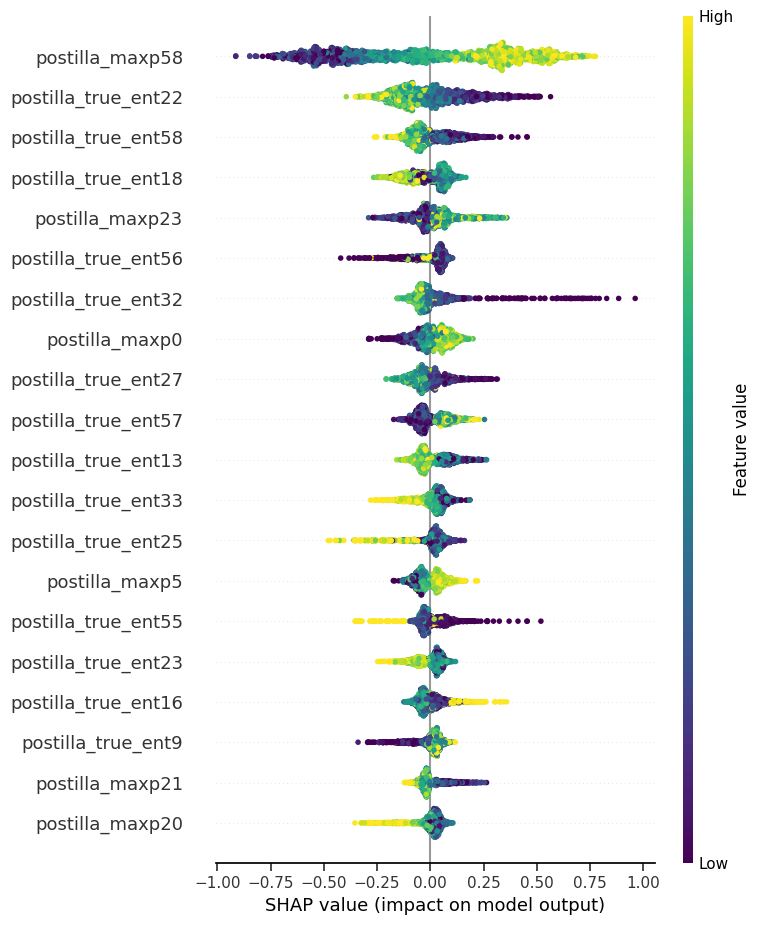

In [66]:
shap.summary_plot(shap_values, X_res, cmap="viridis")

In [67]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if (i.isdigit() or i =='-')))
vals['label'] = vals['label'].astype(int)

In [68]:
K = 10
top_feat_postilla_all = vals.sort_values('value', ascending=False)[:K].label_orig.tolist()

In [69]:
vals.sort_values('value', ascending=False)[:K].value.sum()

0.31295975498050776

In [70]:
vals.groupby('grp').value.sum()

grp
postilla_maxp        0.425461
postilla_true_ent    0.574539
Name: value, dtype: float64



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



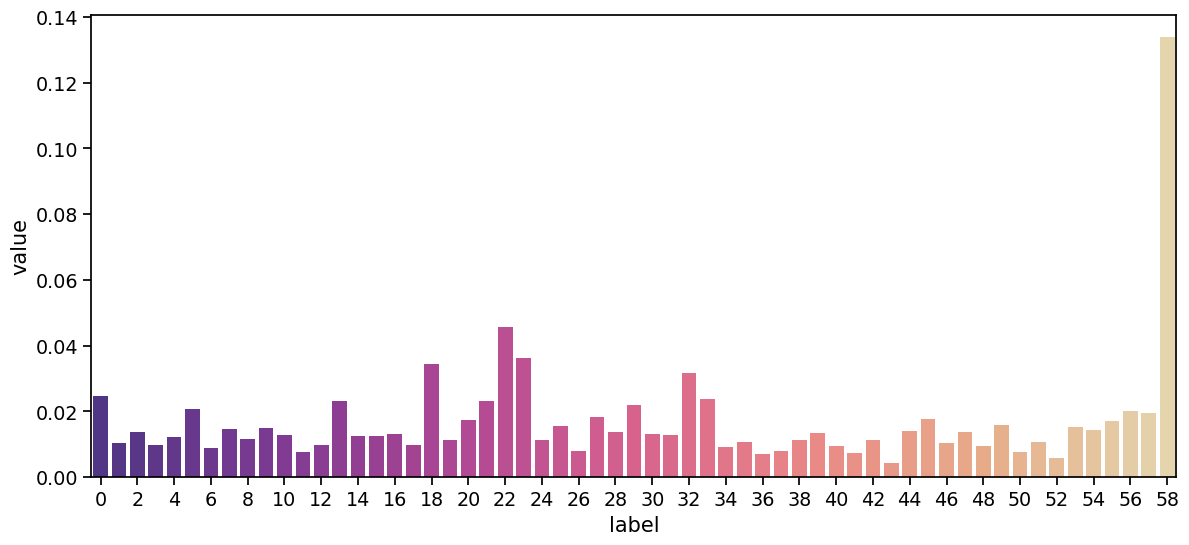

In [71]:
from matplotlib.ticker import MaxNLocator
from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.cartocolors.sequential import agSunset_7
from matplotlib.colors import LinearSegmentedColormap, Normalize


plt.figure(figsize=(14, 6))
ax = plt.gca()

index_importances = vals.sort_index().groupby('label').value.sum().to_frame().reset_index()

# palette = sns.color_palette(agSunset_7, )

norm = Normalize(vmin=0, vmax=index_importances.shape[0] - 1)
color_mapping = {str(label): agSunset_7.mpl_colormap(norm(i)) for i, label in enumerate(index_importances.label)}


sns.barplot(index_importances, x='label', y='value', palette=color_mapping, ax = ax)

ax.xaxis.set_major_locator(MaxNLocator(nbins=32))

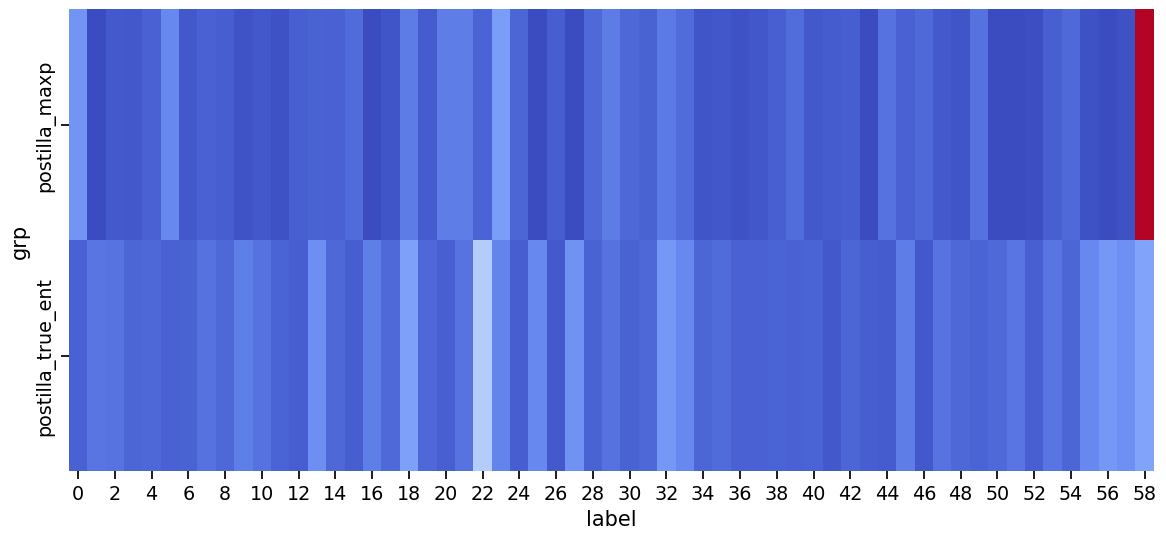

In [72]:
plt.figure(figsize=(14, 6))
_toplot = vals.pivot(index='grp', columns='label', values='value')
ax = plt.gca()
sns.heatmap(_toplot, ax=ax, cbar=False, annot=False, fmt=".2f", annot_kws={"fontsize":6}, cmap="coolwarm")
plt.show()

### postilla: + kl

In [73]:
# all postilla

selected_features = list(df_logitlens_kl_expanded.columns)

# reinstate this if you do not want to spill the first candidate info
# ds = mmg[(mmg.segment=='postilla')][['run', 'pid', 'tokzero', 'true_ent', 'maxp'] + selected_features]
# ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['true_ent', 'maxp']+selected_features).reset_index()
# ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]

############# RECOVER FIRST TOKEN IN GENERATE
# add first generated feature
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero==0)][['run', 'pid', 'tokzero', 'true_ent', 'maxp'] + selected_features ]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['maxp', 'true_ent'] + selected_features).reset_index()
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds1 = ds # .merge(truth, on=['run', 'pid'])
ds1.columns = ['generated_' + col if col[-1].isdigit() else col for col in ds1.columns]

# all postilla
ds = mmg[(mmg.segment=='postilla')][['run', 'pid', 'tokzero', 'true_ent', 'maxp'] + selected_features]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['maxp', 'true_ent'] + selected_features ).reset_index()
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds2 = ds # .merge(truth, on=['run', 'pid'])
ds2.columns = ['postilla_' + col if col[-1].isdigit() else col for col in ds2.columns]

ds = ds1.merge(ds2, on = ['run', 'pid'])
# ds = ds1.merge(ds2, on = ['run', 'pid', 'correct', 'hallucinated'])


############## WARNING THIS BYPASSES THE RECOVER ABOVE
# reinstate this if you do not want to spill the first candidate info
ds = mmg[(mmg.segment=='postilla')][['run', 'pid', 'tokzero', 'true_ent', 'maxp'] + selected_features]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['true_ent', 'maxp']+selected_features).reset_index()
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]


# indexes for kl/iou are _LAYER_TOKEN
# ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

# WARNING here we are dropping duplicates
ds = ds.drop_duplicates(ds.columns[1:-1])

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

y_res_postilla_kl = y_res

X_res.columns = ['postilla_'+col for col in X.columns]

In [74]:
%%time

class_counts = np.bincount(y_res)
class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
sample_weights = np.array([class_weights[y] for y in y_res])

xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)

pred_proba_postilla_kl = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), 
                                     groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})

CPU times: user 2min 26s, sys: 11.8 s, total: 2min 38s
Wall time: 26.4 s


In [75]:
pred = pred_proba_postilla_kl.argmax(axis=1).astype(bool)
print(classification_report(y_res_postilla_kl.values, pred))

              precision    recall  f1-score   support

       False       0.54      0.59      0.57       975
        True       0.62      0.57      0.60      1146

    accuracy                           0.58      2121
   macro avg       0.58      0.58      0.58      2121
weighted avg       0.59      0.58      0.58      2121



In [76]:
y_res_postilla.shape, y_res_postilla_kl.shape, y_res_generated.shape

((2121,), (2121,), (4088,))

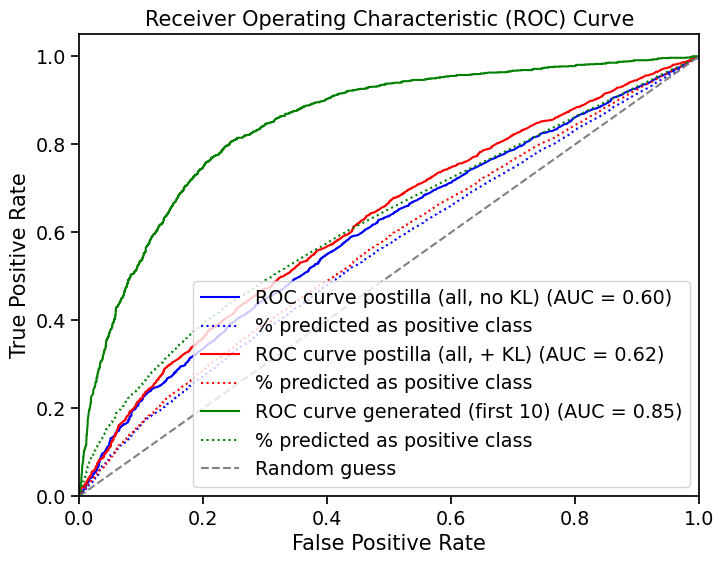

In [77]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res_postilla.values, pred_proba_postilla[:, 1])
true_counts_rel = [(pred_proba_postilla[:, 1] > thr).sum() / pred_proba_postilla.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve postilla (all, no KL) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res_postilla_kl.values, pred_proba_postilla_kl[:, 1])
true_counts_rel = [(pred_proba_postilla_kl[:, 1] > thr).sum() / pred_proba_postilla_kl.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', label=f'ROC curve postilla (all, + KL) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res_generated.values, pred_proba_generated[:, 1])
true_counts_rel = [(pred_proba_generated[:, 1] > thr).sum() / pred_proba_generated.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='green', label=f'ROC curve generated (first {N}) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='green', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

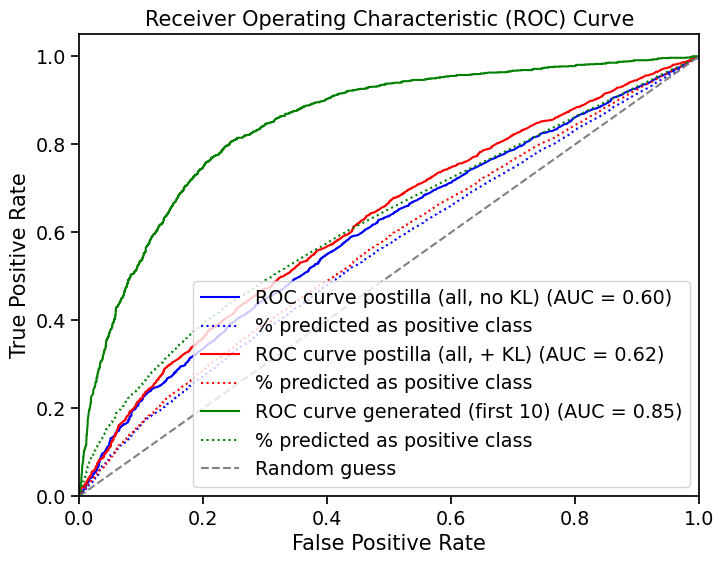

In [78]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res_postilla.values, pred_proba_postilla[:, 1])
true_counts_rel = [(pred_proba_postilla[:, 1] > thr).sum() / pred_proba_postilla.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve postilla (all, no KL) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res_postilla_kl.values, pred_proba_postilla_kl[:, 1])
true_counts_rel = [(pred_proba_postilla_kl[:, 1] > thr).sum() / pred_proba_postilla_kl.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', label=f'ROC curve postilla (all, + KL) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res_generated.values, pred_proba_generated[:, 1])
true_counts_rel = [(pred_proba_generated[:, 1] > thr).sum() / pred_proba_generated.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='green', label=f'ROC curve generated (first {N}) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='green', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### combo: base features generated + postilla

In [86]:
mm[(mm.segment=='postilla')].tokzero.min()

0

In [93]:
# COMBO
# beginning of generate + postilla
N = 10
ds = mm[(mm.segment=='generated') & (mm.tokzero<=N)][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds1 = ds.merge(truth, on=['run', 'pid'])
ds1.columns = ['generated_' + col if col[-1].isdigit() else col for col in ds1.columns]

# all postilla
ds = mm[(mm.segment=='postilla')][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds2 = ds.merge(truth, on=['run', 'pid'])
ds2.columns = ['postilla_' + col if col[-1].isdigit() else col for col in ds2.columns]

In [94]:
ds = ds1.merge(ds2, on = ['run', 'pid', 'correct', 'hallucinated'])

In [95]:
ds.shape, ds1.shape, ds2.shape

((1433, 214), (14330, 37), (1433, 181))

In [96]:
y = ds.correct
pids = ds.pid

X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

X.columns = [c.replace('-', '') for c in X.columns]

# SELECT TOP FEATURES ONLY
X = X[top_feat_postilla_all + top_feat_generated_begin]

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y
pids_res = pids[y_res.index]

In [97]:
# %%time
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)
pred_proba_combo = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), 
                                     groups=pids_res, 
                                     method='predict_proba')

In [98]:
pred = pred_proba_combo.argmax(axis=1).astype(bool)
print(classification_report(y_res.values, pred))

              precision    recall  f1-score   support

       False       0.78      0.62      0.69       605
        True       0.76      0.87      0.81       828

    accuracy                           0.77      1433
   macro avg       0.77      0.75      0.75      1433
weighted avg       0.77      0.77      0.76      1433



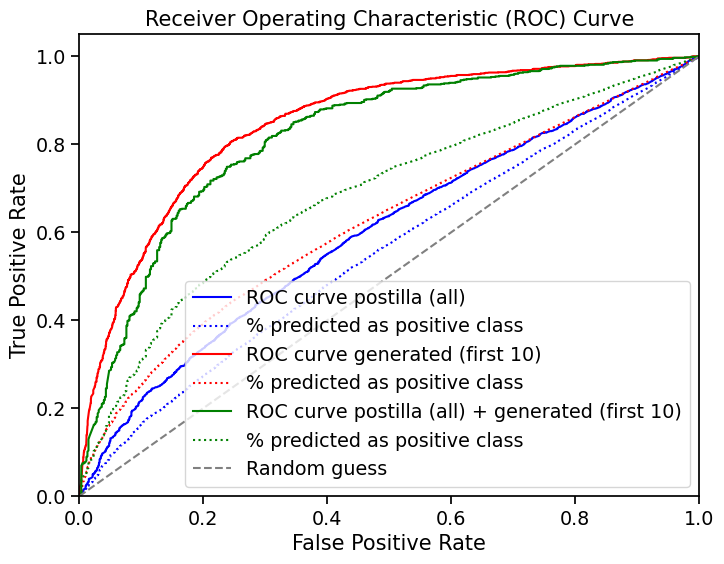

In [99]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

fpr, tpr, thresholds = roc_curve(y_res_postilla.values, pred_proba_postilla[:, 1])
true_counts_rel = [(pred_proba_postilla[:, 1] > thr).sum() / pred_proba_postilla.shape[0] for thr in thresholds]
plt.plot(fpr, tpr, color='blue', label=f'ROC curve postilla (all)')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res_generated.values, pred_proba_generated[:, 1])
true_counts_rel = [(pred_proba_generated[:, 1] > thr).sum() / pred_proba_generated.shape[0] for thr in thresholds]
plt.plot(fpr, tpr, color='red', label=f'ROC curve generated (first {N})')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba_combo[:, 1])
true_counts_rel = [(pred_proba_combo[:, 1] > thr).sum() / pred_proba_combo.shape[0] for thr in thresholds]
plt.plot(fpr, tpr, color='green', label=f'ROC curve postilla (all) + generated (first {N})')
plt.plot(fpr, true_counts_rel, color='green', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [100]:
%%time
import lightgbm as lgb
import shap

model = lgb.LGBMClassifier(n_estimators=100, boosting_type='gbdt')
model.fit(X_res, y_res)

explainer = shap.TreeExplainer(model, X_res)

shap_values = explainer(X_res, check_additivity=False)

[LightGBM] [Info] Number of positive: 828, number of negative: 605
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4838
[LightGBM] [Info] Number of data points in the train set: 1433, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.577809 -> initscore=0.313785
[LightGBM] [Info] Start training from score 0.313785
CPU times: user 7.19 s, sys: 1.39 s, total: 8.58 s
Wall time: 5.93 s


In [101]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if (i.isdigit() or i =='-')))
vals['label'] = vals['label'].astype(int)

In [102]:
vals.groupby('grp').value.sum()

grp
generated_maxp_        0.087833
generated_true_ent_    0.583738
postilla_maxp          0.126787
postilla_true_ent      0.201643
Name: value, dtype: float64



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Axes: xlabel='label', ylabel='value'>

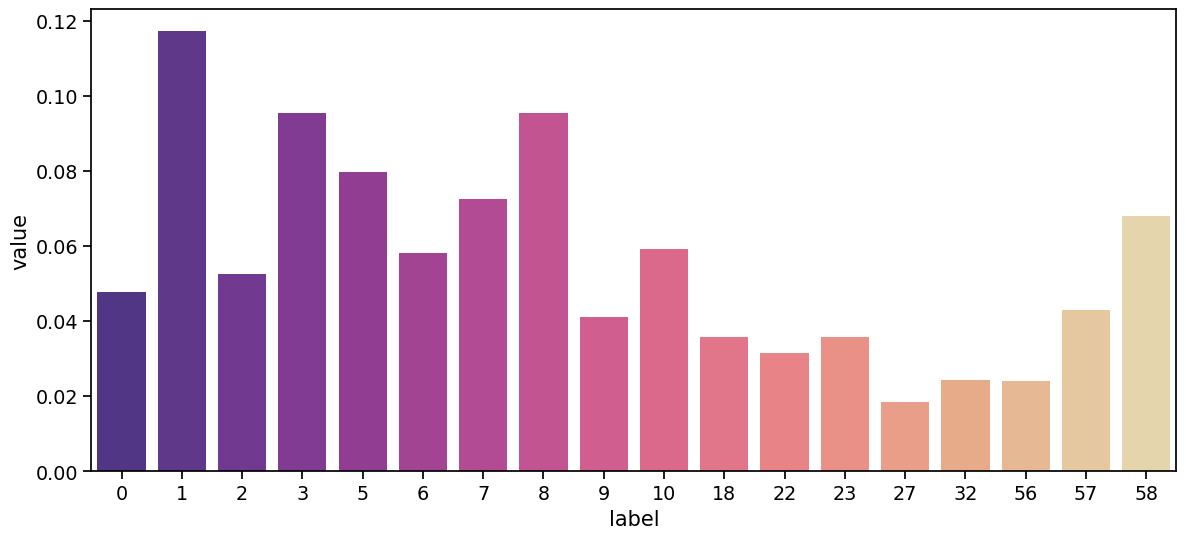

In [103]:
from matplotlib.ticker import MaxNLocator
from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.cartocolors.sequential import agSunset_7
from matplotlib.colors import LinearSegmentedColormap, Normalize


plt.figure(figsize=(14, 6))
ax = plt.gca()

index_importances = vals.sort_index().groupby('label').value.sum().to_frame().reset_index()

# palette = sns.color_palette(agSunset_7, )

norm = Normalize(vmin=0, vmax=index_importances.shape[0] - 1)
color_mapping = {str(label): agSunset_7.mpl_colormap(norm(i)) for i, label in enumerate(index_importances.label)}


sns.barplot(index_importances, x='label', y='value', palette=color_mapping, ax = ax)

# ax.xaxis.set_major_locator(MaxNLocator(nbins=32))

Text(27.44444444444443, 0.5, 'Token index')

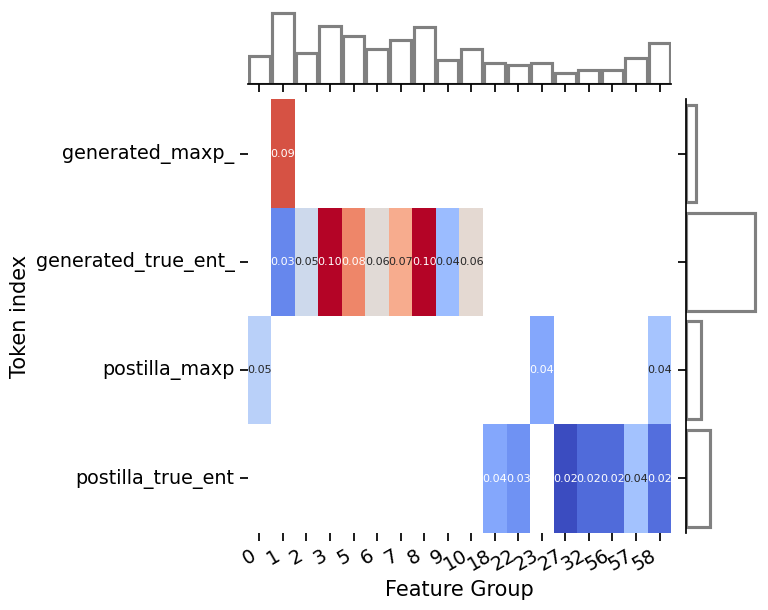

In [104]:
_toplot = vals.pivot(index='grp', columns='label', values='value')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":8}, cmap="coolwarm")
# Draw total bars, both with width 1, but the Y one with horizontal orientation

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.9, fill=False, color='grey')

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.9, fill=False, color='grey')
# Offset value (just half an unit)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

# Need to use this to set the horizontal_alignment
grid.ax_joint.set_xticklabels(
    grid.ax_joint.get_xticklabels(), 
    rotation=30,    
    ha='right'
)
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Feature Group')
grid.ax_joint.set_ylabel('Token index')

### end of input (no candidates provided yet)

In [105]:
# end of input (last NN)
NN = 64
ds = mm[(mm.segment=='input') & (mm.tokzero_end>=-NN)][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero_end', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.merge(truth, on=['run', 'pid'])

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
pids_res = pids[y_res.index]

X_res.columns = ['input_'+col for col in X.columns]

In [106]:
%%time
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)
# pred_proba_instr = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res, method='predict_proba')
pred_proba_input = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res, method='predict_proba')

pred = pred_proba_input.argmax(axis=1).astype(bool)
print(classification_report(y_res.values, pred))

              precision    recall  f1-score   support

       False       0.54      0.59      0.56       605
        True       0.54      0.49      0.52       605

    accuracy                           0.54      1210
   macro avg       0.54      0.54      0.54      1210
weighted avg       0.54      0.54      0.54      1210

CPU times: user 25.8 s, sys: 2.55 s, total: 28.4 s
Wall time: 4.09 s


In [107]:
segments.segment.unique()

array(['preamble', 'instruction', 'input', 'question', 'postilla',
       'generated'], dtype=object)

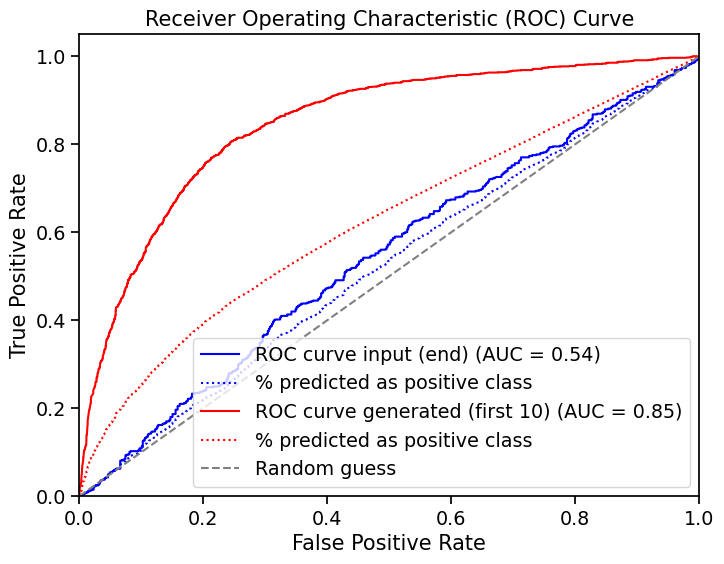

In [108]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba_input[:, 1])
true_counts_rel = [(pred_proba_input[:, 1] > thr).sum() / pred_proba_input.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve input (end) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res_generated.values, pred_proba_generated[:, 1])
true_counts_rel = [(pred_proba_generated[:, 1] > thr).sum() / pred_proba_generated.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', label=f'ROC curve generated (first {N}) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### does adding candidate distance measures add information?

In [109]:
# candidate measures are known at runtime and constant for each prompt

In [110]:
with open('aggrodue.pickle', 'rb') as handle:
    aggrodue = pickle.load(handle)

In [111]:
N = 2
#ds = mm[(mm.segment=='generated') & (mm.tokzero<N)][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
ds = mm[(mm.segment=='postilla')][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.merge(truth, on=['run', 'pid'])

ds = ds[ds.pid.isin(aggrodue.pid.unique())] # something got lost on the way?

In [112]:
# % of prompts showing variance in output across runs (selected features)
(ds.groupby('pid').std() != 0.).sum() / ds.pid.nunique()

run             1.0
maxp0           1.0
maxp1           1.0
maxp2           1.0
maxp3           1.0
               ... 
true_ent56      1.0
true_ent57      1.0
true_ent58      1.0
correct         1.0
hallucinated    1.0
Length: 121, dtype: float64

In [113]:
# WARNING only unique observations
ds = ds.drop_duplicates(ds.columns[1:-2])

In [114]:
ds.shape

(1426, 122)

In [115]:
ds.correct.value_counts()

correct
True     825
False    601
Name: count, dtype: int64

In [116]:
# check variances

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'hallucinated'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y #rus.fit_resample(X, y)

In [117]:
X_res.shape

(1426, 120)

In [118]:
y_res.value_counts()

correct
True     825
False    601
Name: count, dtype: int64

In [119]:
(X_res.groupby('pid').std() != 0.).sum() / X_res.pid.nunique()

maxp0         1.0
maxp1         1.0
maxp2         1.0
maxp3         1.0
maxp4         1.0
             ... 
true_ent55    1.0
true_ent56    1.0
true_ent57    1.0
true_ent58    1.0
correct       1.0
Length: 119, dtype: float64

In [120]:
# dataset 

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

print(X.shape, y.sum())

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]
X_res.columns

(1426, 118) 825


Index(['generated_maxp0', 'generated_maxp1', 'generated_maxp2',
       'generated_maxp3', 'generated_maxp4', 'generated_maxp5',
       'generated_maxp6', 'generated_maxp7', 'generated_maxp8',
       'generated_maxp9',
       ...
       'generated_true_ent49', 'generated_true_ent50', 'generated_true_ent51',
       'generated_true_ent52', 'generated_true_ent53', 'generated_true_ent54',
       'generated_true_ent55', 'generated_true_ent56', 'generated_true_ent57',
       'generated_true_ent58'],
      dtype='object', length=118)

In [121]:
X_res.shape, y_res.shape

((1426, 118), (1426,))

In [122]:
# class weights
class_counts = np.bincount(y_res)
class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
sample_weights = np.array([class_weights[y] for y in y_res])

In [123]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost

#partition cv by prompt
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)

pred_proba = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), 
                               groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})

pred = pred_proba.argmax(axis=1).astype(bool)
print(classification_report(y_res.values, pred))

              precision    recall  f1-score   support

       False       0.52      0.56      0.54       601
        True       0.66      0.62      0.64       825

    accuracy                           0.59      1426
   macro avg       0.59      0.59      0.59      1426
weighted avg       0.60      0.59      0.60      1426

CPU times: user 21.6 s, sys: 2.45 s, total: 24 s
Wall time: 3.39 s


In [124]:
# dataset with candidate measures

add = aggrodue[['pid', 'cand_average_dist_mean', 'cand_max_dist_mean', 'cand_average_jaccard_dist_mean', 'cand_average_jaccard_tok_dist_mean']]
add = add.rename(columns={'cand_average_dist_mean': 'cand_average_dist_mean999', 
                          'cand_max_dist_mean': 'cand_max_dist_mean999', 
                          'cand_average_jaccard_dist_mean': 'cand_average_jaccard_dist_mean999',
                          'cand_average_jaccard_tok_dist_mean': 'cand_average_jaccard_tok_dist_mean999'})
ds_ = ds.merge(add, on='pid')

y = ds_.correct
pids = ds_.pid
X = ds_.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

print(X.shape, y.sum())

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y #rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]
X_res.columns

(1426, 122) 825


Index(['generated_maxp0', 'generated_maxp1', 'generated_maxp2',
       'generated_maxp3', 'generated_maxp4', 'generated_maxp5',
       'generated_maxp6', 'generated_maxp7', 'generated_maxp8',
       'generated_maxp9',
       ...
       'generated_true_ent53', 'generated_true_ent54', 'generated_true_ent55',
       'generated_true_ent56', 'generated_true_ent57', 'generated_true_ent58',
       'generated_cand_average_dist_mean999',
       'generated_cand_max_dist_mean999',
       'generated_cand_average_jaccard_dist_mean999',
       'generated_cand_average_jaccard_tok_dist_mean999'],
      dtype='object', length=122)

In [125]:
X_res.shape, y_res.shape

((1426, 122), (1426,))

In [126]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost

#partition cv by prompt
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)

pred_proba2 = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), 
                                groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})

pred2 = pred_proba2.argmax(axis=1).astype(bool)
print(classification_report(y_res.values, pred2))

              precision    recall  f1-score   support

       False       0.52      0.57      0.54       601
        True       0.66      0.61      0.64       825

    accuracy                           0.59      1426
   macro avg       0.59      0.59      0.59      1426
weighted avg       0.60      0.59      0.60      1426

CPU times: user 23.2 s, sys: 2.11 s, total: 25.3 s
Wall time: 3.58 s


In [127]:
import xgboost
import shap

model = xgboost.XGBClassifier(n_estimators=100, booster='gblinear').fit(X_res, y_res, sample_weight=sample_weights)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

In [128]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if (i.isdigit() or i =='-')))
vals['label'] = vals['label'].astype(int)

In [ ]:
from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

index_importances = vals.sort_index().groupby('label').value.sum()

plt.figure(figsize=(14, 6))
ax = plt.gca()
sns.barplot(index_importances, palette=palette,ax=ax)

ax.xaxis.set_major_locator(MaxNLocator(nbins=16))

In [ ]:
# compare with and without candidate measures

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba2[:, 1])
true_counts_rel = [(pred_proba2[:, 1] > thr).sum() / pred_proba2.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC with add (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### variable window: combo (postilla + generated)

In [117]:
ds1 = mmg[(mmg.segment=='postilla')][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
ds2 = mmg[(mmg.segment=='generated')][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
mingen = mmg[(mmg.segment=='generated')].groupby('pid').tokzero.max().min()
postilla_shift = mmg[(mmg.segment=='postilla')].tokzero.max()
ds2.tokzero += postilla_shift + 1
dss = pd.concat([ds1, ds2]).copy()

In [118]:
dss.shape

(1246844, 6)

In [ ]:
%%time

outs_combo = []

for K in range(0, postilla_shift+mingen+1, 1):
    clear_output(wait=True)
    print(K, end='\r')
    ds = dss[(dss.tokzero<=K)][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
    ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['maxp', 'true_ent']).reset_index()
    ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
    ds = ds.merge(truth, on=['run', 'pid'])
    
    # WARNING only unique observations
    ds = ds.drop_duplicates(ds.columns[1:-1])
    
    for r in range(8):
        ds = ds.sample(frac=1) # randomism
        y = ds.correct
        pids = ds.pid
        X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])
        X_res, y_res = X, y
        X_res.columns = ['generated_'+col for col in X.columns]
        pids_res = pids
        
        class_counts = np.bincount(y_res)
        class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
        sample_weights = np.array([class_weights[y] for y in y_res])
        
        pred_proba = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=5), 
                               groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})
    
        outs_combo.append((r, K, pred_proba, y_res))

In [ ]:
aucs = []
for r, K, pred_proba, y_res in outs_combo:
    fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
    true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
    roc_auc = auc(fpr, tpr)
    aucs.append((r, K, roc_auc))

In [ ]:
aucs_ = pd.DataFrame(aucs, columns=['r', 'k', 'auc'])

from scipy.ndimage import gaussian_filter1d
aucs_['auc_smooth'] = gaussian_filter1d(aucs_.auc, sigma=3)

# postilla
ax = sns.lineplot(aucs_, x='k', y='auc')
ax.set_title("progressive classification AUC")
ax.axvline(postilla_shift + 1, color="darkred", linestyle="--", label="prompt end")

plt.show()

### variable window: postilla + generated + kl

In [121]:
selected_features = list(df_logitlens_kl_expanded.columns) + ['true_ent', 'maxp']

ds1 = mmg[(mmg.segment=='postilla')][['run', 'pid', 'tokzero'] + selected_features]
ds2 = mmg[(mmg.segment=='generated')][['run', 'pid', 'tokzero'] + selected_features]

mingen = mmg[(mmg.segment=='generated')].groupby('pid').tokzero.max().min()
postilla_shift = mmg[(mmg.segment=='postilla')].tokzero.max()

ds2.tokzero += postilla_shift + 1
dss = pd.concat([ds1, ds2]).copy()

In [122]:
dss.shape

(1247062, 46)

In [123]:
ds1.shape, ds2.shape

((886200, 46), (360862, 46))

In [124]:
%%time

outs_generated_kl = []

besties_ = [b.replace('generated_', '') for b in besties]
besties_layers = list(set((['_'.join(b.split('_')[:-1]) for b in besties_])))

selected_features = ['true_ent', 'maxp'] + besties_layers

for K in range(0, postilla_shift+mingen+1, 1):
    clear_output(wait=True)
    print(K, end='\r')
    ds = dss[(dss.tokzero<=K)][['run', 'pid', 'tokzero'] + selected_features]
    ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()
    ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
    ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
    ds = ds.merge(truth, on=['run', 'pid'])
    
    # WARNING only unique observations
    ds = ds.drop_duplicates(ds.columns[1:-1])
    
    for r in range(8):
        ds = ds.sample(frac=1)
        y = ds.correct
        pids = ds.pid
        X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])
        X_res, y_res = X, y
        X_res.columns = ['generated_'+col for col in X.columns]
        pids_res = pids
        
        class_counts = np.bincount(y_res)
        class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
        sample_weights = np.array([class_weights[y] for y in y_res])
        
        pred_proba = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=5), 
                               groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})
    
        outs_generated_kl.append((r, K, pred_proba, y_res))

CPU times: user 1h 48min 27s, sys: 14min 45s, total: 2h 3min 12s
Wall time: 18min 17s


### kl only

In [125]:
selected_features = list(df_logitlens_kl_expanded.columns)

ds1 = mmg[(mmg.segment=='postilla')][['run', 'pid', 'tokzero'] + selected_features]
ds2 = mmg[(mmg.segment=='generated')][['run', 'pid', 'tokzero'] + selected_features]

mingen = mmg[(mmg.segment=='generated')].groupby('pid').tokzero.max().min()
postilla_shift = mmg[(mmg.segment=='postilla')].tokzero.max()

ds2.tokzero += postilla_shift + 1
dss = pd.concat([ds1, ds2]).copy()

In [126]:
%%time

outs_generated_kl_only = []

besties_ = [b.replace('generated_', '') for b in besties]
besties_layers = list(set((['_'.join(b.split('_')[:-1]) for b in besties_])))

selected_features = besties_layers

for K in range(0, postilla_shift+mingen+1, 1):
    clear_output(wait=True)
    print(K, end='\r')
    ds = dss[(dss.tokzero<=K)][['run', 'pid', 'tokzero'] + selected_features]
    ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()
    ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
    ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
    ds = ds.merge(truth, on=['run', 'pid'])
    
    # WARNING only unique observations
    ds = ds.drop_duplicates(ds.columns[1:-1])
    
    for r in range(8):
        ds = ds.sample(frac=1)
        y = ds.correct
        pids = ds.pid
        X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])
        X_res, y_res = X, y
        X_res.columns = ['generated_'+col for col in X.columns]
        pids_res = pids
        
        class_counts = np.bincount(y_res)
        class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
        sample_weights = np.array([class_weights[y] for y in y_res])
        
        pred_proba = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=5), 
                               groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})
    
        outs_generated_kl_only.append((r, K, pred_proba, y_res))

CPU times: user 1h 1min 5s, sys: 9min 22s, total: 1h 10min 27s
Wall time: 9min 42s


In [127]:
# generated with entropy/maxp features

aucs = []
for r, K, pred_proba, y_res in outs_combo:
    fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
    true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
    roc_auc = auc(fpr, tpr)
    aucs.append((r, K, roc_auc))
    
aucs_1 = pd.DataFrame(aucs, columns=['r', 'k', 'auc'])
aucs_1['src'] = 'entropy/maxp'


# generated adding kl
aucs = []
for r, K, pred_proba, y_res in outs_generated_kl:
    fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
    true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
    roc_auc = auc(fpr, tpr)
    aucs.append((r, K, roc_auc))
    
aucs_2 = pd.DataFrame(aucs, columns=['r', 'k', 'auc'])
aucs_2['src'] = 'kl'

# generated with kl only
aucs = []
for r, K, pred_proba, y_res in outs_generated_kl_only:
    fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
    true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
    roc_auc = auc(fpr, tpr)
    aucs.append((r, K, roc_auc))
    
aucs_3 = pd.DataFrame(aucs, columns=['r', 'k', 'auc'])
aucs_3['src'] = 'kl_only'


# aucs_ = pd.concat([aucs_1, aucs_2], axis=1)

#from scipy.ndimage import gaussian_filter1d
#aucs_['auc_smooth'] = gaussian_filter1d(aucs_.auc, sigma=3)

#sns.lineplot(aucs_, x='k', y='auc').set_title("AUC generated 1>14")
#plt.show()

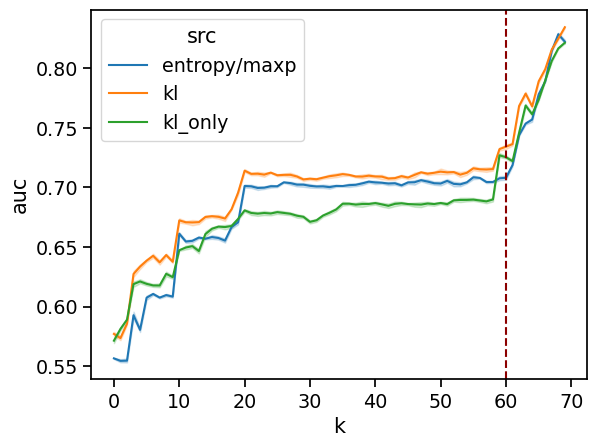

In [128]:
aucs_ = pd.concat([aucs_1, aucs_2, aucs_3], axis=0)

from scipy.ndimage import gaussian_filter1d
aucs_['auc_smooth'] = gaussian_filter1d(aucs_.auc, sigma=3)

ax = sns.lineplot(aucs_, x='k', y='auc', hue='src')
ax.set_title("")

ax.axvline(postilla_shift + 1, color="darkred", linestyle="--", label="prompt end")
# ax.axvline(postilla_shift + 10, color="navy", linestyle="--", label="prompt end")

plt.show()

### double check postilla with and without

In [129]:
%%time

selected_features = ['shape', 'true_ent', 'maxp'] # + list(df_logitlens_kl_expanded.columns)

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='postilla')][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

# WARNING here we are dropping duplicates
ds = ds.drop_duplicates(ds.columns[1:-1])

print(ds.shape)

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

y_res_postilla2_nokl = y_res

X_res.columns = ['generated_'+col for col in X.columns]

(1652, 184)
CPU times: user 612 ms, sys: 68.6 ms, total: 681 ms
Wall time: 281 ms


In [130]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost

class_counts = np.bincount(y_res)
class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
sample_weights = np.array([class_weights[y] for y in y_res])

#partition cv by prompt
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)

pred_proba_postilla2_nokl = cross_val_predict(xgb_model, X_res, y_res_postilla2_nokl, cv=GroupKFold(n_splits=10), 
                               groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})

CPU times: user 22 s, sys: 3.72 s, total: 25.7 s
Wall time: 3.85 s


In [131]:
%%time

selected_features = ['true_ent', 'maxp'] + besties_layers # + list(df_logitlens_kl_expanded.columns)

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='postilla')][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

# WARNING here we are dropping duplicates
ds = ds.drop_duplicates(ds.columns[1:-1])

print(ds.shape)

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

y_res_postilla2_kl = y_res

X_res.columns = ['generated_'+col for col in X.columns]

(4381, 304)
CPU times: user 1.26 s, sys: 324 ms, total: 1.58 s
Wall time: 323 ms


In [132]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost

class_counts = np.bincount(y_res)
class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
sample_weights = np.array([class_weights[y] for y in y_res])

#partition cv by prompt
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)

pred_proba_postilla2_kl = cross_val_predict(xgb_model, X_res, y_res_postilla2_kl, cv=GroupKFold(n_splits=10), 
                               groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})

CPU times: user 41.6 s, sys: 3.64 s, total: 45.2 s
Wall time: 6.79 s


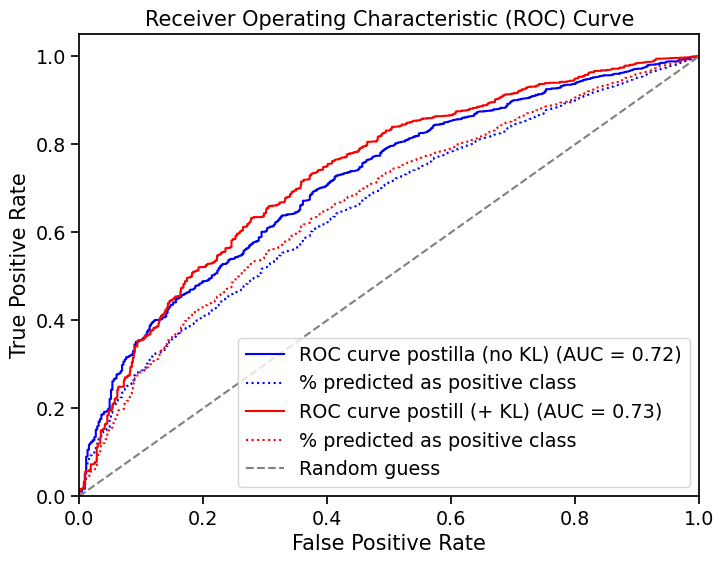

In [133]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res_postilla2_nokl.values, pred_proba_postilla2_nokl[:, 1])
true_counts_rel = [(pred_proba_postilla2_nokl[:, 1] > thr).sum() / pred_proba_postilla2_nokl.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve postilla (no KL) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res_postilla2_kl.values, pred_proba_postilla2_kl[:, 1])
true_counts_rel = [(pred_proba_postilla2_kl[:, 1] > thr).sum() / pred_proba_postilla2_kl.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', label=f'ROC curve postill (+ KL) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [134]:
y_res_postilla2_kl.shape, y_res_postilla2_nokl.shape

((4381,), (1652,))